<a href="https://colab.research.google.com/github/SvisBee/3.34/blob/master/DS_Dash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn plotly dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Загрузка данных
users = pd.read_csv("users_test_data.csv")
applications = pd.read_csv("applications_test_data_final.csv")
status_changes = pd.read_csv("status_changes_test_data.csv")

In [ ]:
roles_map = {
    "visitor": 1,
    "candidate": 2,
    "external_user": 3
}

statuses_map = {
  "предзаявка": 1,
  "на рассмотрении": 2,
  "отклонена": 3,
  "принята": 4
}



courses_map = {
  "Java development": 1,
  "Fronted development": 2,
  "Testing": 3,
  "Analitics": 4,
  "DevOps Engineer": 5,
  "Data Engineer": 6,
  "System Engineer": 7,
  "Data Science": 8,
  "Test-Analyst": 9
}

In [ ]:
role_names = {v: k for k, v in roles_map.items()}
status_names = {v: k for k, v in statuses_map.items()}
course_names = {v: k for k, v in courses_map.items()}


# Объединяем данные
merged = applications.merge(users, on="user_id", how="left")

# Проверяем и добавляем столбец created_at
if 'created_at' not in applications.columns:
    applications['created_at'] = pd.date_range(start="2023-01-01", periods=len(applications), freq='D')

if 'created_at' not in merged.columns:
    merged['created_at'] = applications['created_at']

# Метрики
total_applications = len(applications)
accepted_applications = len(applications[applications["status_id"] == 4])
rejected_applications = len(applications[applications["status_id"] == 3])
pending_applications = len(applications[applications["status_id"] == 2])

<ipython-input-5-d40a5caa1f24>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='role_id', data=users, palette='viridis')


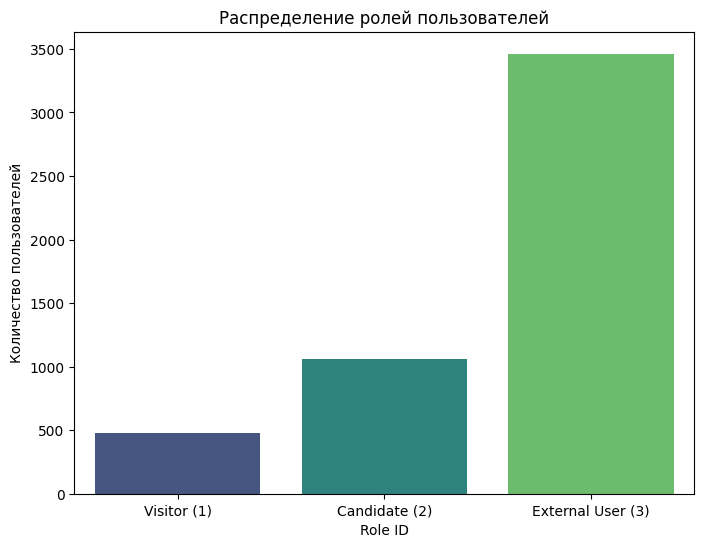

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='role_id', data=users, palette='viridis')
plt.title('Распределение ролей пользователей')
plt.xlabel('Role ID')
plt.ylabel('Количество пользователей')
plt.xticks(ticks=[0,1,2], labels=['Visitor (1)', 'Candidate (2)', 'External User (3)'])
plt.show()


<ipython-input-6-b87576ea59b4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status_id', data=applications, palette='magma')


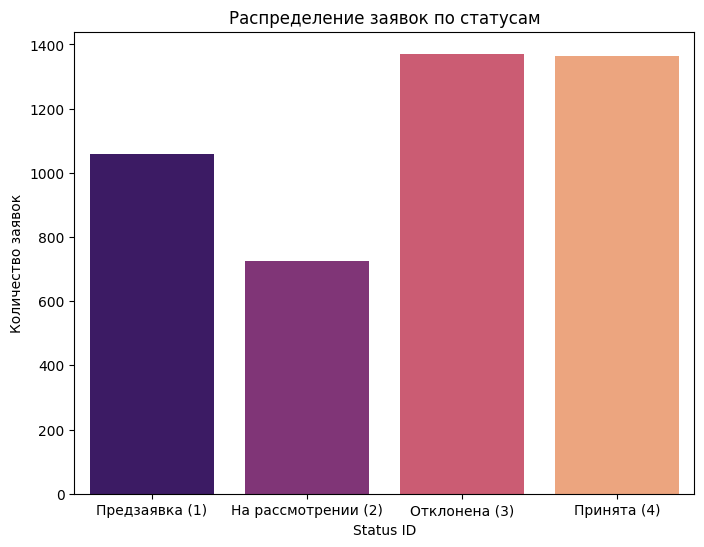

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='status_id', data=applications, palette='magma')
plt.title('Распределение заявок по статусам')
plt.xlabel('Status ID')
plt.ylabel('Количество заявок')
plt.xticks(ticks=[0,1,2,3], labels=['Предзаявка (1)', 'На рассмотрении (2)', 'Отклонена (3)', 'Принята (4)'])
plt.show()


In [ ]:
# Преобразуем данные для удобства
merged['role_name'] = merged['role_id'].map({v: k for k, v in roles_map.items()})
merged['status_name'] = merged['status_id'].map({v: k for k, v in statuses_map.items()})

# Группируем данные
role_status_counts = merged.groupby(['role_name', 'status_name']).size().reset_index(name='count')

# Создаем группированный барчарт
fig = px.bar(
    role_status_counts,
    x='role_name',
    y='count',
    color='status_name',
    title='Взаимосвязь Ролей Пользователей и Статусов Заявок',
    labels={
        'role_name': 'Роль Пользователя',
        'count': 'Количество Заявок',
        'status_name': 'Статус Заявки'
    },
    barmode='group',  # Для группированного отображения
    color_discrete_sequence=['orange', 'yellow', 'red', 'green']  # Настроенные цвета
)

# Улучшение визуализации
fig.update_layout(
    xaxis_title='Роли Пользователей',
    yaxis_title='Количество Заявок',
    legend_title='Статус Заявки',
    template='plotly_white'
)

fig.show()

In [ ]:
# Создаём целевую переменную
users['has_application'] = users['role_id'].apply(lambda x: 1 if x in [2,3] else 0)

# Преобразуем категориальные признаки в числовые
label_encoders = {}
for column in ['first_name', 'last_name', 'phone', 'email', 'city']:
    le = LabelEncoder()
    users[column] = le.fit_transform(users[column].astype(str))
    label_encoders[column] = le

# Добавляем количество заявок как дополнительный признак
application_counts = applications.groupby('user_id').size().reset_index(name='app_count')
users = users.merge(application_counts, on='user_id', how='left')
users['app_count'] = users['app_count'].fillna(0)

# Определяем признаки и целевую переменную
X = users.drop(['user_id', 'has_application'], axis=1)
y = users['has_application']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Обучение модели Логистической Регрессии
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Предсказания
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_proba_log_reg = log_reg.predict_proba(X_test_scaled)[:,1]

# Оценка модели
print("Логистическая Регрессия:")
print(classification_report(y_test, y_pred_log_reg))


Логистическая Регрессия:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       900

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [ ]:
# Обучение модели Случайного Леса
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Предсказания
y_pred_rf = rf_clf.predict(X_test_scaled)
y_pred_proba_rf = rf_clf.predict_proba(X_test_scaled)[:,1]

# Оценка модели
print("Случайный Лес:")
print(classification_report(y_test, y_pred_rf))


Случайный Лес:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       900

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



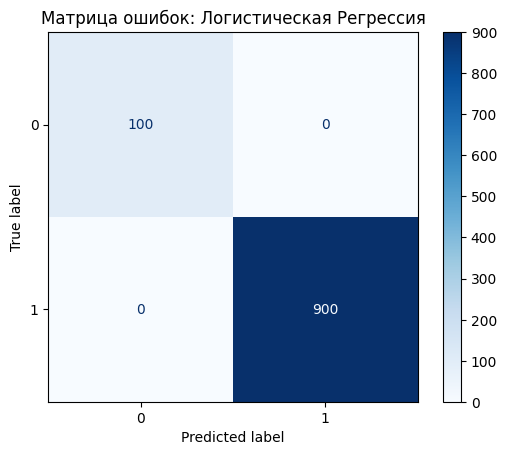

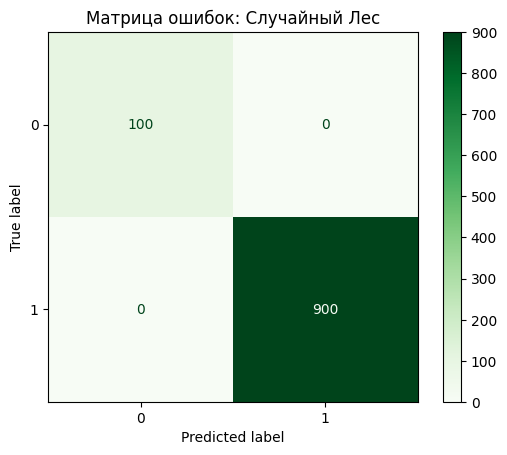

In [ ]:


# Матрица ошибок для Логистической Регрессии
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=[0, 1])
disp_log_reg.plot(cmap='Blues')
plt.title('Матрица ошибок: Логистическая Регрессия')
plt.show()

# Матрица ошибок для Случайного Леса
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1])
disp_rf.plot(cmap='Greens')
plt.title('Матрица ошибок: Случайный Лес')
plt.show()


In [ ]:
# ROC-кривая для Логистической Регрессии
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_proba_log_reg)
roc_auc_log = roc_auc_score(y_test, y_pred_proba_log_reg)

# ROC-кривая для Случайного Леса
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Построение ROC-кривых с использованием graph_objects
fig = go.Figure()

# ROC-кривая для Логистической Регрессии
fig.add_trace(
    go.Scatter(
        x=fpr_log, y=tpr_log,
        mode='lines',
        name=f'Логистическая Регрессия (AUC = {roc_auc_log:.2f})',
        line=dict(color='blue')
    )
)

# ROC-кривая для Случайного Леса
fig.add_trace(
    go.Scatter(
        x=fpr_rf, y=tpr_rf,
        mode='lines',
        name=f'Случайный Лес (AUC = {roc_auc_rf:.2f})',
        line=dict(color='red')
    )
)

# Добавление диагонали случайных предсказаний
fig.add_trace(
    go.Scatter(
        x=[0, 1], y=[0, 1],
        mode='lines',
        name='Случайные Предсказания',
        line=dict(color='grey', dash='dash')
    )
)

# Настройка оформления графика
fig.update_layout(
    title='ROC-кривые моделей',
    xaxis_title='False Positive Rate (FPR)',
    yaxis_title='True Positive Rate (TPR)',
    legend=dict(x=0.6, y=0.1),
    template='plotly_white'
)

fig.show()


<ipython-input-13-42f092af3f6b>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




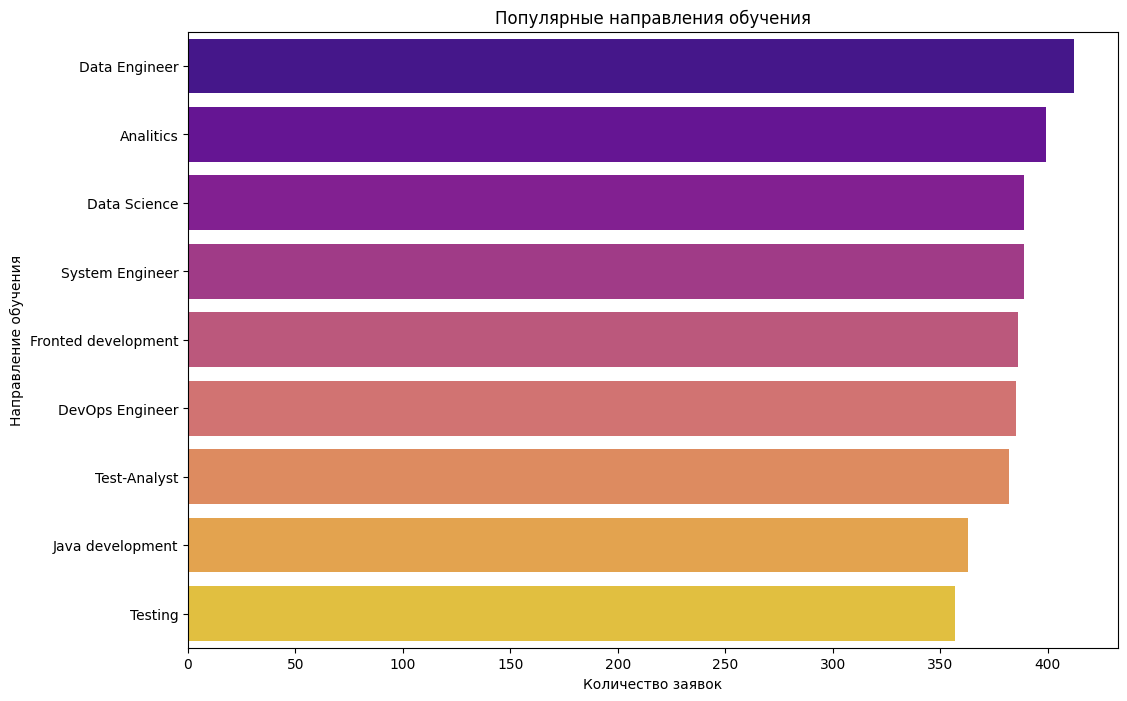

In [ ]:
# Считаем количество заявок по каждому направлению
popular_courses = applications['course_id'].value_counts().reset_index()
popular_courses.columns = ['course_id', 'count']
popular_courses['course_name'] = popular_courses['course_id'].map(course_names)

# Визуализация
plt.figure(figsize=(12,8))
sns.barplot(x='count', y='course_name', data=popular_courses, palette='plasma')
plt.title('Популярные направления обучения')
plt.xlabel('Количество заявок')
plt.ylabel('Направление обучения')
plt.show()


In [ ]:
# Преобразуем `creation_time` в формат datetime
applications['creation_time'] = pd.to_datetime(applications['creation_time'])

# Группируем данные по дате
time_series = applications.groupby(applications['creation_time'].dt.date).size().reset_index(name='count')
time_series.columns = ['date', 'count']

# Убеждаемся, что даты отсортированы
time_series['date'] = pd.to_datetime(time_series['date'])
time_series = time_series.sort_values('date').set_index('date')

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import pandas as pd

# Настройка модели
model = ExponentialSmoothing(
    time_series['count'],
    seasonal='add',
    seasonal_periods=7  # Недельная сезонность
).fit()

# Прогноз на 2 года вперёд
prediction_periods = 2 * 365  # Прогноз на 2 года (примерно 730 дней)
prediction = model.forecast(steps=prediction_periods)

# Создание временной оси для прогноза
prediction_index = pd.date_range(start=time_series.index[-1], periods=prediction_periods + 1, freq='D')[1:]
prediction = pd.Series(prediction.values, index=prediction_index)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



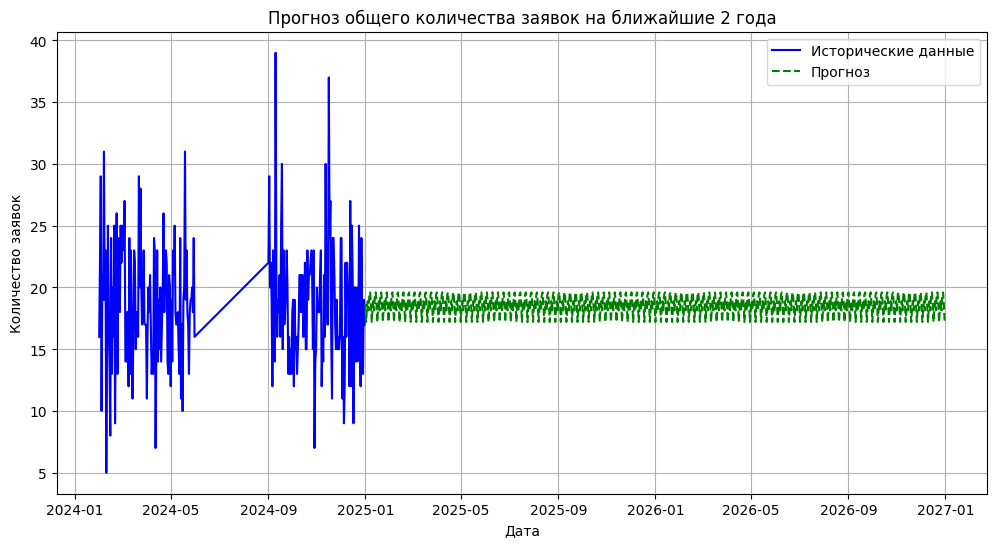

In [ ]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(time_series['count'], label="Исторические данные", color='blue')
plt.plot(prediction, label="Прогноз", color='green', linestyle='dashed')
plt.title("Прогноз общего количества заявок на ближайшие 2 года")
plt.xlabel("Дата")
plt.ylabel("Количество заявок")
plt.legend()
plt.grid()
plt.show()

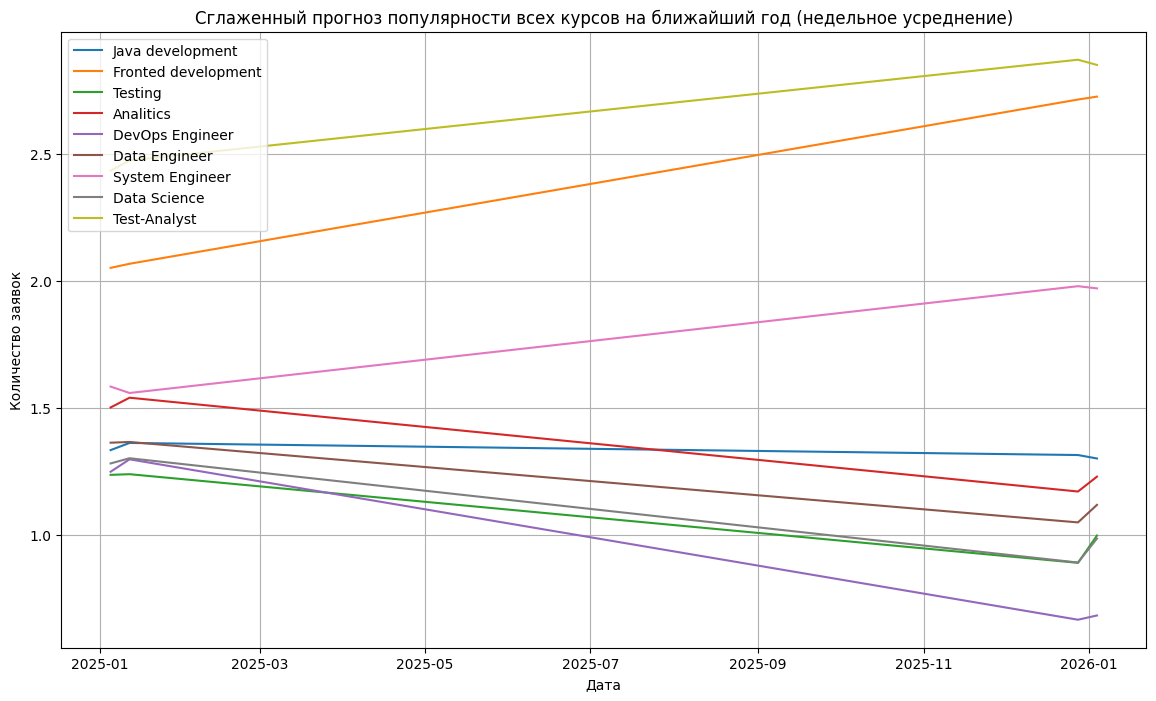

In [ ]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Инвертируем карту, чтобы искать по ID
courses_map_reversed = {v: k for k, v in courses_map.items()}

# Загрузка данных
applications = pd.read_csv("applications_test_data_final.csv")

# Преобразуем `creation_time` в формат datetime
applications['creation_time'] = pd.to_datetime(applications['creation_time'])

# Группируем данные по курсам и дате
course_time_series = applications.groupby(['course_id', applications['creation_time'].dt.date]).size().reset_index(name='count')
course_time_series.columns = ['course_id', 'date', 'count']

# Убеждаемся, что даты отсортированы
course_time_series['date'] = pd.to_datetime(course_time_series['date'])
course_time_series = course_time_series.sort_values(['course_id', 'date'])

# Прогнозирование для всех курсов
forecasts = {}
forecast_periods = 365  # Прогноз на 1 год

for course_id in course_time_series['course_id'].unique():
    # Подготовка данных для текущего курса
    course_data = course_time_series[course_time_series['course_id'] == course_id]
    course_data = course_data.set_index('date').asfreq('D').fillna(0)  # Заполнение пропусков нулями

    # Построение модели
    try:
        model = ExponentialSmoothing(
            course_data['count'],
            trend='add',
            seasonal='add',
            seasonal_periods=7  # Недельная сезонность
        ).fit()

        # Прогноз
        forecast = model.forecast(steps=forecast_periods)
        forecast_index = pd.date_range(start=course_data.index[-1], periods=forecast_periods + 1, freq='D')[1:]
        forecast_series = pd.Series(forecast.values, index=forecast_index)

        # Сглаживание прогноза (например, недельное)
        smoothed_forecast = forecast_series.resample('W').mean()
        forecasts[courses_map_reversed[course_id]] = smoothed_forecast
    except Exception as e:
        print(f"Ошибка при прогнозировании курса {courses_map_reversed.get(course_id, 'Неизвестный курс')}: {e}")

# Визуализация всех прогнозов
plt.figure(figsize=(14, 8))
for course_name, forecast in forecasts.items():
    plt.plot(forecast, label=f"{course_name}")

plt.title("Сглаженный прогноз популярности всех курсов на ближайший год (недельное усреднение)")
plt.xlabel("Дата")
plt.ylabel("Количество заявок")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Словарь для ролей
role_names = {1: 'Visitor', 2: 'Candidate', 3: 'External User'}

# Добавляем колонку role_name
users['role_name'] = users['role_id'].map(role_names)

# Группировка по ролям
role_distribution = users.groupby('role_name').size().reset_index(name='count')

In [ ]:
# Группировка заявок по курсам и месяцам
applications['creation_time'] = pd.to_datetime(applications['creation_time'])
popular_courses_by_month = applications.groupby(
    [applications['creation_time'].dt.to_period('M'), 'course_id']
).size().reset_index(name='count')

popular_courses_by_month['creation_time'] = popular_courses_by_month['creation_time'].dt.to_timestamp()
popular_courses_by_month['course_name'] = popular_courses_by_month['course_id'].map(course_names)

In [ ]:
merged = applications.merge(users, on="user_id", how="left")
status_names = {1: 'Предзаявка', 2: 'На рассмотрении', 3: 'Отклонена', 4: 'Принята'}

# Добавляем читаемые названия в merged
merged['role_name'] = merged['role_id'].map(role_names)
merged['status_name'] = merged['status_id'].map(status_names)

role_status_counts = merged.groupby(['role_name', 'status_name']).size().reset_index(name='app_count')


In [ ]:
# Создание простого дашборда с Dash
app = dash.Dash(__name__)

# Подготовка данных для дашборда
top_courses = popular_courses.head(10)  # Топ-10 популярных курсов

app.layout = html.Div([
    html.H1("Аналитика Заявок Пользователей"),

    html.Div([
        html.H2("Распределение Ролей Пользователей"),
        dcc.Graph(
            figure=px.pie(
                role_distribution,
                names='role_name',  # Используем читаемые названия ролей
                title='Распределение ролей пользователей',
                values='count',     # Количество пользователей
                color='role_name',
                color_discrete_sequence=px.colors.sequential.RdBu
            )
        )
    ]),

    html.Div([
        html.H2("Популярность курсов по месяцам"),
        dcc.Graph(
            figure=px.bar(
                popular_courses_by_month,
                x='count',
                y='course_name',
                color='course_name',
                animation_frame='creation_time',
                orientation='h',
                title='Изменение популярности курсов по месяцам',
                labels={'count': 'Количество заявок', 'course_name': 'Название курса'},
                color_discrete_sequence=px.colors.sequential.Viridis
            )
        )
    ]),

    html.Div([
        html.H2("Взаимосвязь Ролей и Статусов Заявок"),
        dcc.Graph(
            figure=px.sunburst(
                role_status_counts,
                path=['role_name', 'status_name'],  # Иерархия: Роль -> Статус
                values='app_count',  # Количество заявок
                title='Взаимосвязь ролей пользователей и статусов заявок',
                color='status_name',  # Цвет по статусу
                color_discrete_sequence=px.colors.sequential.RdBu,
                hover_data={'app_count': True}  # Показываем количество заявок при наведении
            )
        )
    ]),

    html.Div([
        html.H2("ROC-кривая Моделей Прогнозирования"),
        dcc.Graph(
            figure=fig  # Используем ранее созданную фигуру с ROC-кривыми
        )
    ]),

    html.Div([
        html.H2("Прогноз общего количества заявок"),
        dcc.Graph(
            id="forecast_graph",
            figure={
                "data": [
                    go.Scatter(
                        x=time_series.index,
                        y=time_series['count'],
                        mode='lines',
                        name="Исторические данные",
                        line=dict(color='blue')
                    ),
                    go.Scatter(
                        x=forecast.index,
                        y=prediction,
                        mode='lines',
                        name="Прогноз",
                        line=dict(color='green', dash='dash')
                    )
                ],
                "layout": go.Layout(
                    title="Прогноз общего количества заявок на ближайшие 2 года",
                    xaxis_title="Дата",
                    yaxis_title="Количество заявок",
                    template="plotly_white",
                    xaxis=dict(
                        range=[
                            time_series.index.min(),  # Минимальная дата из временных рядов
                            forecast.index.max()      # Максимальная дата из прогноза
                        ]
                    ),
                    yaxis=dict(
                        autorange=True  # Автоматическое масштабирование оси Y
                    )
                )
            }
        )
    ]),

    html.Div([
        html.H2("Сглаженный прогноз популярности курсов"),
        dcc.Graph(
            id="smoothed_course_forecasts",
            figure={
                "data": [
                    go.Scatter(
                        x=forecast.index, y=forecast,
                        mode='lines', name=course_name,
                        line=dict(dash="dash")
                    ) for course_name, forecast in forecasts.items()
                ],
                "layout": go.Layout(
                    title="Сглаженные прогнозы для курсов на ближайший год",
                    xaxis_title="Дата",
                    yaxis_title="Количество заявок",
                    template="plotly_white"
                )
            }
        )
    ])

])

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>